# Importing Basic Packages

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

# Downloading TAURAAT
## Request from USGS Web Service

In [7]:
import requests
from io import StringIO
import concurrent.futures
import csv

In [25]:
def usgs_site_inventory(rfile='./data/site-visit_html_request_code.txt'):
    from datetime import date
    with open(rfile, 'r') as f:
        line = f.readline()

    request = requests.get(line)
    text_file = request.text

    wfile = f'usgs_sv-inventory_{date.today()}.txt'

    with open(f'./data/{wfile}', 'w', newline='\n') as f:
        f.write(text_file)

    return wfile

In [26]:
print(usgs_site_inventory())

usgs_sv-inventory_2023-03-09


In [31]:
usgs_inventory = pd.read_csv('./data/usgs_sv-inventory_2023-03-09.txt', delimiter='\t', skiprows=31, usecols=np.arange(0, 12), quoting=csv.QUOTE_NONE,  converters={'site_no': str}, low_memory=False).loc[1:,:]

In [44]:
usgs_inventory.head()

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,state_cd,huc_cd,drain_area_va,contrib_drain_area_va
1,USGS,01010000,"St. John River at Ninemile Bridge, Maine",ST,46.70055556,-69.71555560,S,NAD83,23,01010001,1341,1341
2,USGS,01010070,"Big Black River near Depot Mtn, Maine",ST,46.89388889,-69.75166670,S,NAD83,23,01010001,171,171
3,USGS,01010500,"St. John River at Dickey, Maine",ST,47.11305556,-69.08805560,S,NAD83,23,01010001,2680,2680
4,USGS,01011000,"Allagash River near Allagash, Maine",ST,47.06972220,-69.07944440,S,NAD83,23,01010002,1478,1229
5,USGS,01012790,Unnamed trib to N. Fork McLean B nr St. Agatha...,ST,47.22550000,-68.34011110,5,NAD83,23,01010003,0.56,0.56


In [45]:
def usgs_site_visit(site_number):

    url = f'https://waterdata.usgs.gov/nwis/measurements?site_no={site_number}&agency_cd=USGS&format=rdb_expanded'
    try:
        request = requests.get(url)
        text_file = request.text
        if "No site" not in text_file:
            df = pd.read_csv(StringIO(text_file), delimiter='\t', skiprows=14, usecols=np.arange(0, 32), quoting=csv.QUOTE_NONE,  converters={'site_no': str}).loc[1:,:]
            print("processing:", site_number)
            return df
        else:
            print("processing:", site_number, "No site found")
            return pd.DataFrame()
    except pd.errors.ParserError as err:
        print("processing:", site_number, err)
        return pd.DataFrame()
    except:
        print("processing:", site_number, "Unexpected Error!")
        return pd.DataFrame()


In [ ]:
with concurrent.futures.ThreadPoolExecutor() as exe:
    dataset = list(exe.map(usgs_site_visit, usgs_inventory['site_no'].to_list()))

In [47]:
from datetime import date
dataset = pd.concat(dataset)
dataset.to_csv(f'./data/TAURAAT-{date.today()}.csv', sep=',', encoding='utf-8', index=False)

In [52]:
print(dataset.shape)
dataset['site_no'].value_counts().describe()

(4548324, 32)


count    73126.000000
mean        62.198452
std        174.289668
min          1.000000
25%          1.000000
50%          5.000000
75%         27.000000
max       7007.000000
Name: site_no, dtype: float64

In [55]:
candidate_columns = ['discharge_va', 'gage_height_va', 'chan_width', 'chan_area', 'chan_velocity']

tau_no_zero = dataset[(dataset[candidate_columns] != 0).all(axis=1)]
tau_no_nan = tau_no_zero.dropna(axis=0, subset=candidate_columns)

In [56]:
print(tau_no_nan.shape)
tau_no_nan['site_no'].value_counts().describe()

(3487737, 32)


count    31728.000000
mean       109.926154
std        197.221586
min          1.000000
25%          6.000000
50%         24.000000
75%        138.000000
max       6590.000000
Name: site_no, dtype: float64

## Merging data from HYDRoSWOT
### Select Subset of HYDRoSWOT with Desired Columns

In [73]:
HYDRoSWOT = pd.read_csv('./HYDRoSWOT/SWOT_ADCP_Dataset.csv', converters={'site_no': str}, low_memory=False)
usgs_fm = pd.read_csv('./USGS_Field-measurements.csv', converters={'site_no': str}, low_memory=False)

In [4]:
HYDRoSWOT_subset_columns = ['site_no', 'station_nm', 'dec_lat_va', 'dec_long_va', 'site_tp_cd', 'drain_area_va', 'contrib_drain_area_va']
HYDRoSWOT_subset = HYDRoSWOT[HYDRoSWOT_subset_columns]
HYDRoSWOT_subset.drop_duplicates(subset='site_no', keep='first', inplace=True)

In [7]:
df = pd.merge(usgs_fm, HYDRoSWOT_subset, how="left", on=["site_no"])
reordering_columns=['site_no', 'station_nm', 'dec_lat_va', 'dec_long_va', 'site_tp_cd', 'drain_area_va', 'contrib_drain_area_va', 'measurement_nu', 'measurement_dt', 'tz_cd', 'q_meas_used_fg', 'party_nm', 'site_visit_coll_agency_cd', 'gage_height_va', 'discharge_va', 'measured_rating_diff', 'gage_va_change', 'gage_va_time', 'control_type_cd', 'discharge_cd', 'chan_nu', 'chan_name', 'meas_type', 'streamflow_method', 'velocity_method', 'chan_discharge', 'chan_width', 'chan_area', 'chan_velocity', 'chan_stability', 'chan_material', 'chan_evenness', 'long_vel_desc', 'horz_vel_desc', 'vert_vel_desc', 'chan_loc_cd', 'chan_loc_dist']
tauraat = df[reordering_columns]
tauraat["measurement_dt"] = pd.to_datetime(tauraat["measurement_dt"])
print(tauraat.shape)

(2802532, 37)


C:\Users\SERFANI\AppData\Local\Temp\ipykernel_10272\4006118527.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tauraat["measurement_dt"] = pd.to_datetime(tauraat["measurement_dt"])


In [8]:
tauraat.head()

,site_no,station_nm,dec_lat_va,dec_long_va,site_tp_cd,drain_area_va,contrib_drain_area_va,measurement_nu,measurement_dt,tz_cd,...,chan_area,chan_velocity,chan_stability,chan_material,chan_evenness,long_vel_desc,horz_vel_desc,vert_vel_desc,chan_loc_cd,chan_loc_dist
0,01010000,"St. John River at Ninemile Bridge, Maine",46.700556,-69.715556,ST,1341.0,1341.0,1,1950-11-28,NaN,...,NaN,NaN,UNSP,UNSP,UNSP,unkn,UNSP,UNSP,UNSP,NaN
1,01010000,"St. John River at Ninemile Bridge, Maine",46.700556,-69.715556,ST,1341.0,1341.0,2,1950-11-29,NaN,...,NaN,NaN,UNSP,UNSP,UNSP,unkn,UNSP,UNSP,UNSP,NaN
2,01010000,"St. John River at Ninemile Bridge, Maine",46.700556,-69.715556,ST,1341.0,1341.0,17,1952-05-01,NaN,...,NaN,NaN,UNSP,UNSP,UNSP,unkn,UNSP,UNSP,UNSP,NaN
3,01010000,"St. John River at Ninemile Bridge, Maine",46.700556,-69.715556,ST,1341.0,1341.0,18,1952-05-02,NaN,...,NaN,NaN,UNSP,UNSP,UNSP,unkn,UNSP,UNSP,UNSP,NaN
4,01010000,"St. John River at Ninemile Bridge, Maine",46.700556,-69.715556,ST,1341.0,1341.0,24,1953-04-09,NaN,...,NaN,NaN,UNSP,UNSP,UNSP,unkn,UNSP,UNSP,UNSP,NaN


In [9]:
tauraat.to_csv("./tauraat-2022-10-24.csv", sep=',', encoding='utf-8', index=False)

# TAURAAT Description
## Reading Dataset

In [60]:
tauraat = pd.read_csv('./tauraat-2022-10-24.csv', converters={'site_no': str}, low_memory=False)

## USGS Field Measurements Methods

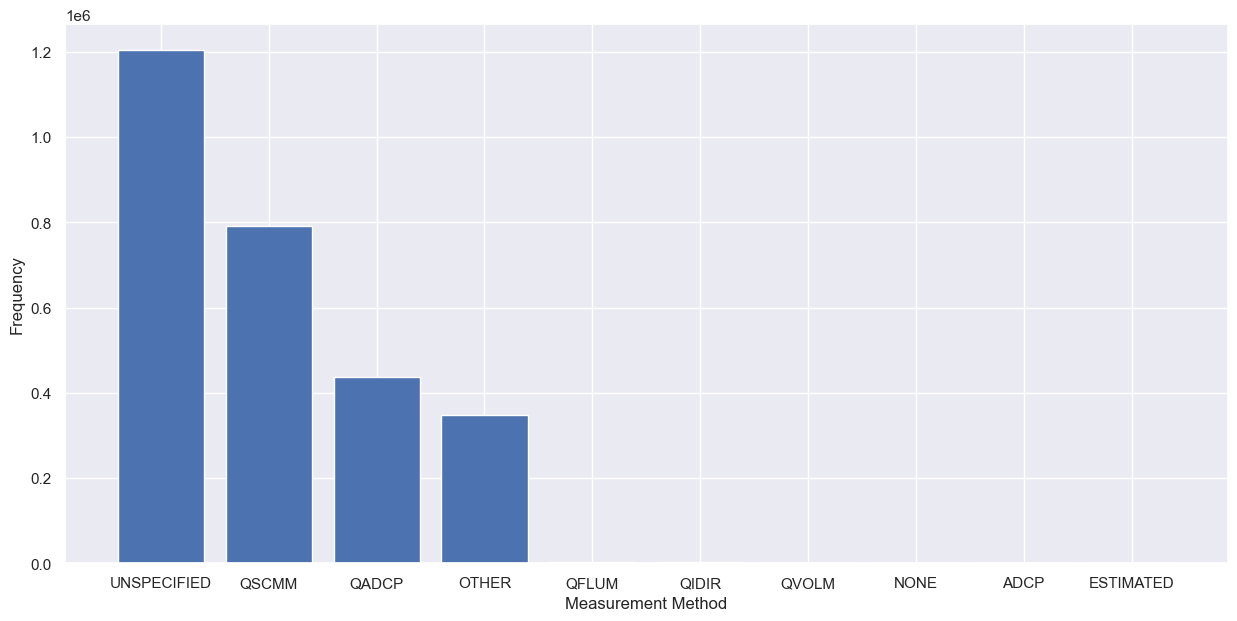

In [69]:
sfm = tauraat['streamflow_method'].value_counts().reset_index().rename(columns={'index': 'sfm', 'streamflow_method': 'freq'})
sfm.iloc[0,0]='UNSPECIFIED'
sfm.iloc[3,0]='OTHER'
sfm.iloc[-1,0]='ESTIMATED'
sfm.iloc[-2,0]='ADCP'
sfm.iloc[-3,0]='NONE'

sfm.to_csv('data/sfm_data.csv', sep=',', encoding='utf-8', index=False)

fig, ax = plt.subplots(figsize=(15,7))
ax.bar(sfm['sfm'], sfm['freq'])
ax.set_ylabel('Frequency')
ax.set_xlabel("Measurement Method")
# plt.savefig('data/vm_barchart.png')
plt.show()

## Merging data from NHDPlusV2
### Reading csv files for NHDPlus Gage locations and Flowline Networks

In [ ]:
nhdp_gage = pd.read_csv('data/NHDPlus_GageLoc.csv', converters={'SOURCE_FEA': str, 'FLComID': str}, low_memory=False)
nhdp_net = pd.read_csv('data/NHDPlus_NHDFlowline_Network.csv', usecols=['COMID', 'FTYPE', 'StreamOrde', 'SLOPE'], converters={'COMID': str}, low_memory = True)

In [ ]:
candidates = ['SOURCE_FEA', 'FLComID', 'STATE_CD', 'STATE', 'DASqMi', 'DASqKm', 'LatSite', 'LonSite']
nhdp_gage = nhdp_gage[candidates]
nhdp_gage.rename(columns={'SOURCE_FEA': 'site_no', 'FLComID': 'COMID'}, inplace=True)

In [ ]:
df = pd.merge(tauraat, nhdp_gage, how="left", on=["site_no"])

In [ ]:
df2 = pd.merge(df, nhdp_net, how="left", on=["COMID"])

In [ ]:
print(tauraat.shape) # (2802532, 37)
print(nhdp_gage.shape) # (28164, 8)
print(nhdp_net.shape) # (2691339, 4)
print(df2.shape) # (2802532, 47)

In [ ]:
joined_comid = pd.read_csv('data/Joined_USGS_Gages_COMID_GMGM.csv', usecols=['site_no', 'COMID', 'FTYPE', 'StreamOrde', 'SLOPE'], converters={'COMID': str, 'site_no': str}, low_memory=False)

In [ ]:
# Removed site_no = `05357190`, `11452905`, `13095700` in the text editor
# site_no = '01643613' -> recieved values from  COMID = '4507448'
# joined_comid[joined_comid['COMID'] == '4507448']
# joined_comid.loc[joined_comid['site_no'] == '01643613', 'COMID'] = '4507448'
# joined_comid.loc[joined_comid['site_no'] == '01643613', 'FTYPE'] = 'ArtificialPath'
# joined_comid.loc[joined_comid['site_no'] == '01643613', 'StreamOrde'] = 7.0
# joined_comid.loc[joined_comid['site_no'] == '01643613', 'SLOPE'] = 1.e-05

In [ ]:
df3 = tauraat.set_index('site_no').combine_first(joined_comid.set_index('site_no'))
df3.reset_index(drop=False, inplace=True) # (2802532, 47)

In [ ]:
df3.to_csv('/data/TAURAAT-HYDRoSWOT-NHDPlusV2.csv', sep=',', encoding='utf-8', index=False)

## Excluded Site Stations

In [26]:
in_HYDRoSWOT = ['02204134', '05429510', '07348500', '07353970', '08013630', '08012770', '08013650', '08013850', '08013947', '08027150', '08105897', '15120650', '15304600', '15305050', '15305352', '15305420', '15305300', '15305350', '15305650', '15305698', '15305260', '15305450', '15355000', '302134096091800', '55559999', '600954134422900', '605008135104100', '620322135395300', '631020139395400', '633300139475100', '66666609']

In [29]:
excluded_sites = HYDRoSWOT[HYDRoSWOT['site_no'].isin(in_HYDRoSWOT)]
excluded_sites = excluded_sites.drop_duplicates(subset="site_no", keep='first')
excluded_sites.to_csv('data/excluded_sites_unique.csv', sep=',', encoding='utf-8', index=False)